In [73]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifierCV
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

def ww( df, key, value  ):
    """
        Function to calculate ratio of value_yes / total_yes_in_dataset

            example: ( Technician and yes / TOTAL Technician ) / ( TOTAL yes / TOTAL INS )

        ratio greater than 1 means a bias, above 1,3 assumed as threshold
    """


    #TOTAL INSTANCES
    #TOTAL YES LABELS
    TOTAL = len( df )
    NUM_YES = sum(df[ 'y' ] == 'yes')

    value_mask = df[ key ] == value
    DF_VAL = df[ value_mask ]
    num_of_value = sum( value_mask )
    num_value_YES = sum( DF_VAL['y'] == 'yes' )
    
    value_yes_ratio = num_value_YES / num_of_value
    total_yes_ratio = NUM_YES / TOTAL

    return value_yes_ratio / total_yes_ratio
    
data = pd.read_csv('term-deposit-marketing-2020.csv')
data.drop( columns = ['contact','duration'], inplace = True )
data.dropna( axis = 0, inplace = True )
data.columns


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'day', 'month', 'campaign', 'y'],
      dtype='object')

In [74]:

def cat_to_num( method, data ):
    new_col = list()

    if isinstance( data, pd.DataFrame ):
        columns = data.columns
        print(columns)
        for col in columns:
            temp =  set( data[ col ] )
            temp = list( temp )
            print(  )
            for i in range(len(temp)):
                temp[i] = str(col) + '_' + str(temp[i])
            new_col = new_col + temp



    new = np.array(method.fit_transform( data ))

    return new, new_col


def pca():
    #pca transformation for dimension reduction
    pass
    



def preprocess( level_columns = [ 3 ], cat_columns = [ 1,2,4,6,7,9,10 ] ):
    #process data for training

    #read data and 
    data = pd.read_csv('term-deposit-marketing-2020.csv')
    data.drop( columns = ['contact','duration'], inplace = True )
    data.dropna( axis = 0, inplace = True )

    X, Y, columns = prepare( data, level_columns, cat_columns, LabelEncoder(), OneHotEncoder(sparse=False), MinMaxScaler() )
    
    X, X_t, Y, Y_t = train_test_split( X,Y, test_size = 0.3, stratify = Y )

    ind_list = np.array( [ x for x in range( X.shape[ 0 ] ) ] )
    
    return X, X_t, Y, Y_t, ind_list, columns



def prepare(  df, LCC ,CC, level_enc, cat_enc, scaler ):

    """
      Given dataframe with target column name --y--
      All nan values are dropped
      CC for categorical feature column positions
      method for encoding object
      scaler for scaling object
    """

    y = df.y
    x = df.drop( columns = 'y' )

    NotNum = CC + LCC
    
    NC = [x for x in range( len( x.columns ) ) if x not in NotNum]
    
    LVL = x.iloc[ :, LCC ]
    CAT = x.iloc[ :, CC ]
    NUM = x.iloc[ :, NC ]
    num_cols = list( NUM.columns )
    lvl_cols =  LVL.columns 

    #print(x_C.columns)
    #print(x_N.columns)
    
    LVL, _ = cat_to_num( level_enc, np.array(LVL) )
    LVL = LVL.reshape(-1,1)
    CAT, cat_cols = cat_to_num( cat_enc, CAT )
    DATA = np.concatenate( [ NUM, CAT, LVL ], axis = 1 )
    DATA = scaler.fit_transform( DATA )

    columns = num_cols + cat_cols
    columns = columns + list(lvl_cols)

    y, __ = cat_to_num( level_enc, y )

    return DATA, y, columns




In [80]:


class Cascade( BaseEstimator, ClassifierMixin ):
    def __init__(self, classifiers, args):
        self.th = 0.9

        self.classifiers = classifiers
        self.stage = 0

    def train( self, X, Y ):
        #train current classifier with current training set
        self.classifiers[ self.stage ].fit( X, Y )
    
    def divide_instances( self, X, Y  ):
        #Get predicted probs of training set
        probs = self.classifiers[ self.stage ].predict_proba( X )[ :, 0 ]

        #Mask instances below threshold 
        #Update training set
        #Update index dict
        X = X[ probs < self.th ]
        Y = Y[ probs < self.th ]


    def fit( self, X, Y  ):
        for i in range( len( self.classifiers ) ):
            #train classifier in position --i--
            self.train( X, Y )
            
            #make prediction with probs and separe D' set
            self.divide_instances( X, Y )
            self.stage += 1

    def label_probs( self, y ):

        yy = [ 0 for x in range( len( y ) ) ]
        for i in range( len( y ) ):
            if y[ i ] < 0.7:
                yy[ i ] = 1
            else:
                yy[ i ] = 0
        return yy

    def predict( self, X ):
        #initialize stage
        self.stage = 0
        self.info = {}

        #create index list
        inds = np.array( [ x for x in range( X.shape[ 0 ] ) ] )
        y = np.array( [ self.th for x in range( X.shape[ 0 ] ) ] )

        #start prediction stages
        for clf in self.classifiers:

            #get class 0 probs
            probs = clf.predict_proba( X )[ :, 0 ]

            #save inst under threshold
            self.info[ 'stage_' + str( self.stage ) ] = inds[ probs < self.th ]
            self.info[ 'prob_' + str( self.stage ) ] = probs[ probs < self.th ]

            #update instances
            X = X[ probs < self.th  ]
            #update indexes
            inds = inds[ probs < self.th ]
            
            self.stage += 1

        probs = probs[ probs < self.th ]
        c = 0
        for i in range( len( y ) ):
            if i in inds:
                y[ i ] = probs[ c ]
                c = c + 1
        
        return self.label_probs( y )


X, X_t, Y, Y_t, ind_list, columns = preprocess()

            

Index(['job', 'marital', 'default', 'housing', 'loan', 'month', 'campaign'], dtype='object')









/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [81]:

classifiers = [ ExtraTreesClassifier(), RandomForestClassifier()  ]

ccc = Cascade( classifiers, ind_list )

results = cross_validate( ccc, X, Y, cv = 5, )

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/pytho

In [82]:
np.mean(results[ 'test_score' ])

0.9140357142857143

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# fitting the model
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model.fit(X_t, Y_t)
# plotting feature importances


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
columns

In [ ]:
np.mean(data.duration)

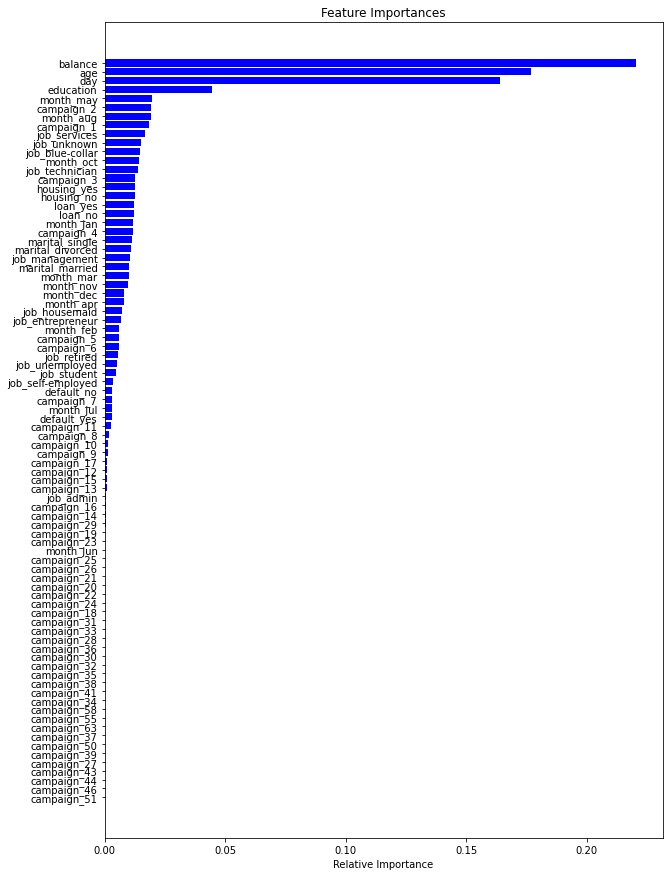

In [84]:

importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


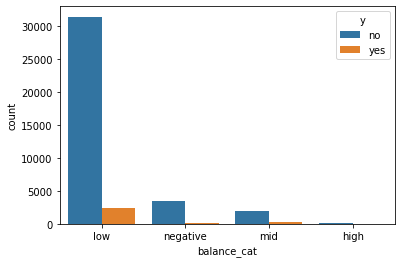

In [ ]:
#BALANCE AS CATEGORIES

data["balance_cat"] = np.nan
data.loc[data['balance'] <0, 'balance_cat'] = 'negative'
data.loc[(data['balance'] >=0)&(data['balance'] <=5000), 'balance_cat'] = 'low'
data.loc[(data['balance'] >5000)&(data['balance'] <=20000), 'balance_cat'] = 'mid'
data.loc[(data['balance'] >20000), 'balance_cat'] = 'high'
sns.countplot(x="balance_cat",hue="y",data=data)
plt.show()


In [ ]:
R = list()
for value in list(set(data.balance_cat) ):
    R.append( (ww( data, 'balance_cat', value ),value) )
print(R)

#The chance is higher with Middle income group 

[(1.0557060914241474, 'high'), (0.7292936143495367, 'negative'), (1.0072889611552895, 'low'), (1.344601896835577, 'mid')]


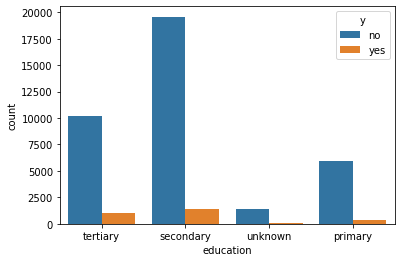

In [ ]:
sns.countplot(x="education",hue="y",data=data)
plt.show()

In [ ]:
R = list()
for value in list(set(data.education) ):
    R.append( (ww( data, 'education', value ),value) )
print(R)

#Tertiary educated people more likely to have term deposit

[(0.7776221064967793, 'primary'), (0.9329602895782414, 'secondary'), (1.2683122597109084, 'tertiary'), (0.8660789358776807, 'unknown')]


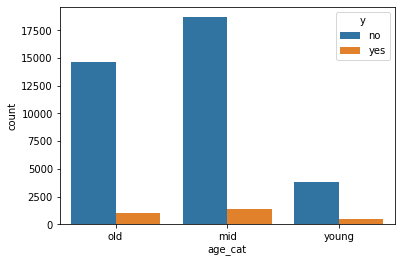

In [88]:
data["age_cat"] = np.nan
data.loc[data['age'] <30, 'age_cat'] = 'young'
data.loc[(data['age'] >=30)&(data['age'] <=42), 'age_cat'] = 'mid'
data.loc[(data['age'] >42)&(data['age'] <=100), 'age_cat'] = 'old'
sns.countplot(x="age_cat",hue="y",data=data)
plt.show()

In [89]:
R = list()
for value in list(set(data.age_cat) ):
    R.append( (ww( data, 'age_cat', value ),value) )
print(R)

#Young people are more likely to have term deposit


[(1.5027262362427836, 'young'), (0.8990839235669148, 'old'), (0.9716022594531467, 'mid')]


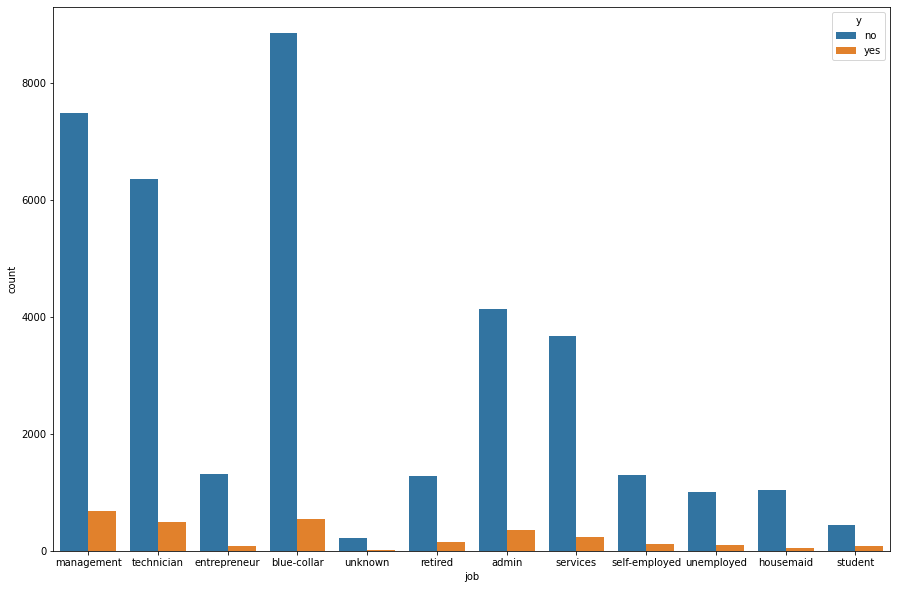

In [15]:
plt.figure(figsize=(15,10))
sns.countplot(x="job",hue="y",data=data)
plt.show()

In [63]:
R = list()
for value in list(set(data.job) ):
    R.append( (ww( data, 'job', value ),value) )
print(R)

#We can see that retired people and students are more likely to buy the service

[(1.001844845881188, 'technician'), (0.9991771482308686, 'unknown'), (1.45138159994156, 'retired'), (2.161444055501666, 'student'), (0.7875415925003665, 'blue-collar'), (1.2010569300984866, 'unemployed'), (0.673453724834432, 'housemaid'), (1.143401490887293, 'management'), (1.0940320551392155, 'self-employed'), (0.8407398510689407, 'services'), (0.8651029275869526, 'entrepreneur'), (1.0814334816735536, 'admin')]


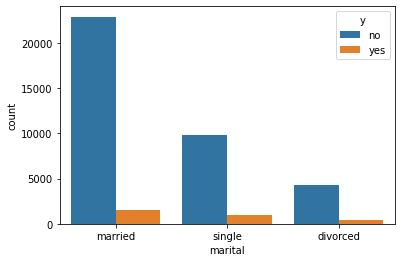

In [17]:
sns.countplot(x="marital",hue="y",data=data)
plt.show()

In [64]:
R = list()
for value in list(set(data.marital) ):
    R.append( (ww( data, 'marital', value ),value) )
print(R)

#We can say that single people are who we should focus on

[(0.8371346116986785, 'married'), (1.3026983995709593, 'single'), (1.1429740711508667, 'divorced')]
